# CS6650 (Web M.Tech): Smart Sensing for Internet of Things
#### Homework 2 (Part B) (Diwali 2024 Semester)
Submission Deadline : Nov 29th, 2024

---
Name: `Dipendu Ghosh`

Roll No: `CS23M509`

Email: `CS23M509@smail.iitm.ac.in`

---

### Localization of IoT Devices

<div style="display:flex; overflow: hidden;">
  <div style="margin:20px;">
    <p>Consider a 2D-grid of MxN cells where we want to locate an IoT device (marked as N) using multilateration. The lower-left corner cell can be treated as the origin (0,0) while the location of the top-right cell is (M, N). Assume that all anchors (A1, A2, and A3) are kept at known locations.</p>
  </div>
</div>

---

In [1]:
import random
import csv
import os
import math
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
from tabulate import tabulate
import statistics

### Task 1: Dataset Generation.

<div style="display:flex; overflow: hidden;">
  <img src="./images/image1.jpg" width="400" height="250" style="margin:20px; object-fit: cover; object-position: top;">
  <div style="margin:20px;">
  <p> Simulate grid of size 100x100. Consider 3 anchors. [10 points]</p>
    <p>a. Randomly generate 100 unique anchor location sets and for each randomly generated anchor location set, generate 50 random unique node locations (programming hint: use a Set ADT while generating the data). All such location points should be within the simulated grid’s bounding box. Write this data to a file, &lt;true_locations.csv&gt;
    
[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>1</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)


[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>2</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)

      …      …       …       …      …      …

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>100</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)
    </p>
    <p></p>
    <p>b. Generate the range values for each node location to the respective anchors and write them to a file &lt;pure_ranges.csv&gt;

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>1</sup>,  .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>1</sup>, .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>50</sup>

      …      …       …       …      …      …

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>100</sup>,  .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>1</sup>, .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>50</sup>
    </p>
    <p></p>
    <p>c. Now generate noisy range values for each node location by adding Gaussian noise to each pure range value as in &lt;pure_ranges.csv&gt;. R<sub>noisy</sub> = R<sub>pure</sub> + N(μ,σ). Generate three datasets, for μ = 0.5, 1 and 2. Assume σ = 0.1 for all cases. Write these data into three files &lt;noisy_ranges_05.csv&gt;, &lt;noisy_ranges_1.csv&gt; and &lt;noisy_ranges_2.csv&gt;
    </p>
  </div>
</div>

In [2]:
##==============================================================PART B. 1:a===========================================================================##

# Function to generate unique random coordinates within a given range
def generate_coordinates(count, lower_bound, upper_bound, existing_coordinates):
    coordinates = set()
    while len(coordinates) < count:
        x = random.randint(lower_bound, upper_bound)
        y = random.randint(lower_bound, upper_bound)
        # Ensure coordinates are unique across all sets
        if (x, y) not in existing_coordinates:
            coordinates.add((x, y))
            existing_coordinates.add((x, y))
    return coordinates

# Function to generate true locations data (anchors and nodes)
def generate_true_locations_data(count, lower_bound, upper_bound):
    true_locations_data = []
    all_generated_coordinates = set()
    
    # Generate the specified number of sets of anchors and corresponding node locations
    for i in range(count):
        # Generate anchor locations (3 coordinates per set)
        anchor_set = generate_coordinates(3, lower_bound, upper_bound, all_generated_coordinates)
        
        # Generate node locations (50 coordinates per set)
        node_set = generate_coordinates(50, lower_bound, upper_bound, all_generated_coordinates)
        
        # Append each pair of anchor and node sets to location_data
        true_locations_data.append({
            "Anchor Set": list(anchor_set),
            "Node Set": list(node_set)
        })
    
    return true_locations_data

# Function to write true locations data to a CSV file
def write_true_locations_to_csv(true_locations_data, file_path):
    # Remove the file if it already exists
    if os.path.exists(file_path):
        os.remove(file_path)
    
    # Write location_data to CSV with each row representing one anchor-node pair
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        # Write each anchor-node pair in a single row
        for idx, data in enumerate(true_locations_data):
            # Format anchor and node coordinates as (x, y) strings
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({x}, {y})" for (x, y) in data["Node Set"]]
            writer.writerow(row)

# Usage example:
true_locations_file_path = 'dipendu_data/true_locations.csv'
if os.path.exists(true_locations_file_path):
    os.remove(true_locations_file_path)

# Generate the true locations data
true_locations_data = generate_true_locations_data(100, 0, 100)

# Write the data to CSV
write_true_locations_to_csv(true_locations_data, true_locations_file_path)

print(f"PART B. 1:a. Generated anchor location and corresponding node location. Data has been written to \"{true_locations_file_path}\"")

##==============================================================PART B. 1:b===========================================================================##

# Function to calculate Euclidean distance between two points (x1, y1) and (x2, y2)
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Function to parse coordinate string '(x, y)' into a tuple (x, y)
def parse_coordinate(coord_str):
    # Strip the parentheses and split by the comma
    return tuple(map(int, coord_str.strip('()').split(', ')))

# Function to generate pure ranges data (anchors, nodes, and their Euclidean distances)
def generate_pure_ranges_data(true_locations_file_path):
    pure_ranges_data = []
    
    # Read the input data from the true_locations_100_sets_unique.csv file
    with open(true_locations_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)  # Read the header
        
        # Find the column indices for anchors and nodes
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]  # Find anchor column indices
        node_indices = [header.index(f"Node_{i+1}") for i in range(50)]  # Find node column indices
        
        # Process each row in the input file
        for row in reader:
            # Extract anchor coordinates (x, y) by parsing the coordinate strings
            anchors = [parse_coordinate(row[anchor_indices[i]]) for i in range(3)]
            
            # Extract node coordinates (x, y) by parsing the coordinate strings
            nodes = [parse_coordinate(row[node_indices[i]]) for i in range(50)]
            
            # Calculate Euclidean distances for each node from the 3 anchors
            ranges = []
            for node in nodes:
                node_ranges = tuple(euclidean_distance(node[0], node[1], anchor[0], anchor[1]) for anchor in anchors)
                ranges.append(node_ranges)
            
            # Store anchor coordinates and calculated ranges as a tuple in the pure_ranges_data list
            pure_ranges_data.append({
                "anchors": anchors,
                "ranges": ranges
            })
    
    return pure_ranges_data

# Function to write pure ranges data to a CSV file
def write_pure_ranges_to_csv(pure_ranges_data, pure_ranges_file_path):
    # Remove the file if it already exists
    if os.path.exists(pure_ranges_file_path):
        os.remove(pure_ranges_file_path)
    
    # Write the true_ranges_data to the output CSV file
    with open(pure_ranges_file_path, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        
        # Write the header for pure_ranges.csv
        output_header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{i+1}" for i in range(50)]
        writer.writerow(output_header)
        
        # Write each row of ranges data to the CSV file
        for data in pure_ranges_data:
            # Flatten the anchor coordinates
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in data["anchors"]]
            
            # Flatten the ranges as (R1, R2, R3) tuples for each node
            range_strs = [f"({r[0]:.2f}, {r[1]:.2f}, {r[2]:.2f})" for r in data["ranges"]]
            
            # Combine the anchors and range tuples into a single row for the CSV
            output_row = anchor_strs + range_strs
            writer.writerow(output_row)

# Usage example:
pure_ranges_file_path = 'dipendu_data/pure_ranges.csv'
if os.path.exists(pure_ranges_file_path):
    os.remove(pure_ranges_file_path)

# Generate the pure ranges data
pure_ranges_data = generate_pure_ranges_data(true_locations_file_path)

# Write the data to the CSV
write_pure_ranges_to_csv(pure_ranges_data, pure_ranges_file_path)

print(f"PART B. 1:b. Generated pure ange values for each node location with repect to each anchor location. Data has been written to \"{pure_ranges_file_path}\"")

##==============================================================PART B. 1:c===========================================================================##

# Gaussian PDF function
def gaussian_noise(mu, sigma):
    """
    Calculates the probability density function of a Gaussian distribution.
    
    Parameters:
    x (float): The value for which to calculate the probability density.
    mu (float): The mean of the Gaussian distribution (default 0).
    sigma (float): The standard deviation of the Gaussian distribution (default 1).
    
    Returns:
    float: The probability density of the value x in the Gaussian distribution.
    """
    # Calculate the Gaussian formula
    random_value = np.random.normal(mu, sigma)
    return random_value

# Function to generate noisy ranges for different values of mu
def generate_noisy_ranges(pure_ranges_file_path):
    # Data structures to store noisy ranges with anchors for different values of mu
    noisy_range_05 = []
    noisy_range_1 = []
    noisy_range_2 = []
    
    # Read the pure_ranges.csv and calculate noisy ranges
    with open(pure_ranges_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)  # Read the header
        
        # Find anchor and range column indices
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]  # Find anchor column indices
        range_indices = [header.index(f"Node_{i+1}") for i in range(50)]  # Find node range column indices
        
        # Process each row in the input file
        for row in reader:
            # Extract anchor coordinates (x, y) from the row
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]
            
            # Extract the ranges for the nodes
            ranges = [tuple(map(float, row[range_indices[i]].strip('()').split(', '))) for i in range(50)]
            
            # Initialize lists to store noisy ranges for this row
            noisy_ranges_05_row = []
            noisy_ranges_1_row = []
            noisy_ranges_2_row = []
            
            # Iterate through each node range (each node has 3 ranges, R1, R2, R3)
            for node_range in ranges:
                # Initialize tuples to store noisy ranges for this particular node
                noisy_range_05_tuple = []
                noisy_range_1_tuple = []
                noisy_range_2_tuple = []
                
                # Iterate through each anchor and corresponding range (R1, R2, R3)
                for range_val in node_range:
                    # For each range (R1, R2, R3) associated with the node, add Gaussian noise
                    noisy_range_05_tuple.append(range_val + gaussian_noise(mu=0.5, sigma=0.1))
                    noisy_range_1_tuple.append(range_val + gaussian_noise(mu=1, sigma=0.1))
                    noisy_range_2_tuple.append(range_val + gaussian_noise(mu=2, sigma=0.1))
                
                # Append the noisy range tuples to their respective lists
                noisy_ranges_05_row.append(tuple(noisy_range_05_tuple))
                noisy_ranges_1_row.append(tuple(noisy_range_1_tuple))
                noisy_ranges_2_row.append(tuple(noisy_range_2_tuple))
            
            # Add the noisy ranges and anchors for this row to the respective data structures
            noisy_range_05.append({
                "anchors": anchors,
                "noisy_ranges": noisy_ranges_05_row
            })
            
            noisy_range_1.append({
                "anchors": anchors,
                "noisy_ranges": noisy_ranges_1_row
            })
            
            noisy_range_2.append({
                "anchors": anchors,
                "noisy_ranges": noisy_ranges_2_row
            })
    
    return noisy_range_05, noisy_range_1, noisy_range_2

# Function to write noisy ranges to CSV file
def write_noisy_ranges_to_csv(noisy_range_data, output_filename):
    with open(output_filename, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        
        # Write the header for noisy ranges CSV
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{i+1}" for i in range(50)]
        writer.writerow(header)
        
        # Write the noisy range data to the CSV file
        for data in noisy_range_data:
            # Flatten the anchor coordinates into strings
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in data["anchors"]]
            
            # Flatten the noisy ranges as (R1, R2, R3) tuples for each node
            range_strs = [f"({r[0]:.2f}, {r[1]:.2f}, {r[2]:.2f})" for r in data["noisy_ranges"]]
            
            # Combine the anchors and noisy range tuples into a single row for the CSV
            output_row = anchor_strs + range_strs
            writer.writerow(output_row)

        # print(f"Data has been written to \"{output_filename}\"")

# File paths for the output CSV files
noisy_ranges_05_file_path = 'dipendu_data/noisy_ranges_05.csv'
if os.path.exists(noisy_ranges_05_file_path):
    os.remove(noisy_ranges_05_file_path)
noisy_ranges_1_file_path = 'dipendu_data/noisy_ranges_1.csv'
if os.path.exists(noisy_ranges_1_file_path):
    os.remove(noisy_ranges_1_file_path)
noisy_ranges_2_file_path = 'dipendu_data/noisy_ranges_2.csv'
if os.path.exists(noisy_ranges_2_file_path):
    os.remove(noisy_ranges_2_file_path)

# Generate the noisy ranges
noisy_range_05, noisy_range_1, noisy_range_2 = generate_noisy_ranges(pure_ranges_file_path)

# Write noisy ranges to their respective files
write_noisy_ranges_to_csv(noisy_range_05, noisy_ranges_05_file_path)
write_noisy_ranges_to_csv(noisy_range_1, noisy_ranges_1_file_path)
write_noisy_ranges_to_csv(noisy_range_2, noisy_ranges_2_file_path)

print(f"PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 0.5, σ = 0.1. Data has been written to \"{noisy_ranges_05_file_path}\"")
print(f"PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 1, σ = 0.1. Data has been written to \"{noisy_ranges_1_file_path}\"")
print(f"PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 2, σ = 0.1. Data has been written to \"{noisy_ranges_2_file_path}\"")

PART B. 1:a. Generated anchor location and corresponding node location. Data has been written to "dipendu_data/true_locations.csv"
PART B. 1:b. Generated pure ange values for each node location with repect to each anchor location. Data has been written to "dipendu_data/pure_ranges.csv"
PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 0.5, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_05.csv"
PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 1, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_1.csv"
PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 2, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_2.csv"


### Task 2: Range Equations. 

<div style="display:flex; overflow: hidden;">
  <img src="./images/image2.jpg" width="400" height="250" style="margin:20px; object-fit: cover; object-position: top;">
  <div style="margin:20px;">
  <p> Generate two random numbers, A in [1, 100] and B in [1, 50]. Choose the A<sup>th</sup> line and the B<sup>th</sup> node location from the files in (a), (b), and (c). [20 + 10 points]</p>
    <p>a. Form the cost function (use root mean square error) using the three range equations for that particular node and anchor locations. Evaluate the “cost value” for all the 100x100 cells for &lt;pure_ranges.csv&gt;, &lt;noisy_ranges_05.csv&gt;, &lt;noisy_ranges_1.csv&gt; and &lt;noisy_ranges_2.csv&gt;. While
evaluating your cost function put (X = i and Y = j) where i and j are integers in [0,99].
Visualize the normalized cost values (scale: 0 to 1) in the form of a heatmap. Plot the 4 heatmaps. Don’t interpolate your heatmaps.
    </p>
    <p></p>
    <p>b. Summarize your observations. Did you realize the fact that we are trying to use a brute-force approach to scan all possible cells for the solution? Is the cell with the global minima near (or, how far from) the actual node location? (Cost value = 0 for non-noisy case) Are there local minima present in the noisy cases?
    </p>
  </div>
</div>



Anchors Co-ordinates -> [(3, 29), (54, 25), (51, 17)]
Node Co-ordinates -> (73, 73)
Pure Ranges Minima Co-ordinates -> (73, 73)
Noisy Ranges 0.5 Minima Co-ordinates -> (74, 73)
Noisy Ranges 1 Minima Co-ordinates -> (73, 74)
Noisy Ranges 2 Minima Co-ordinates -> (75, 74)


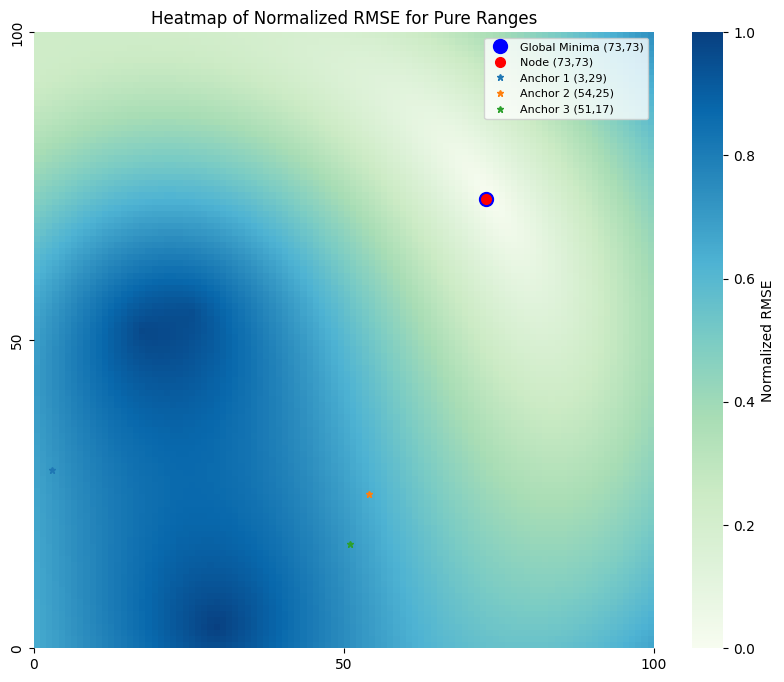

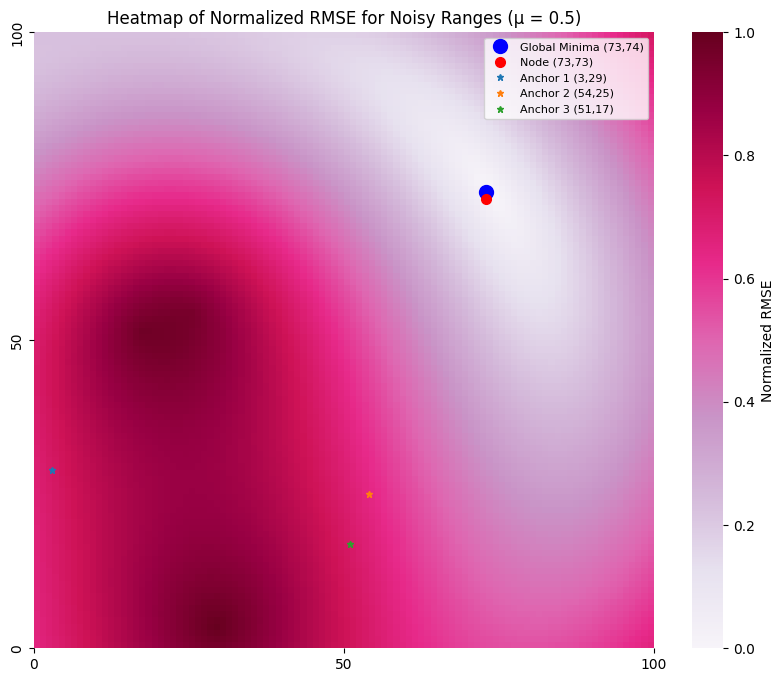

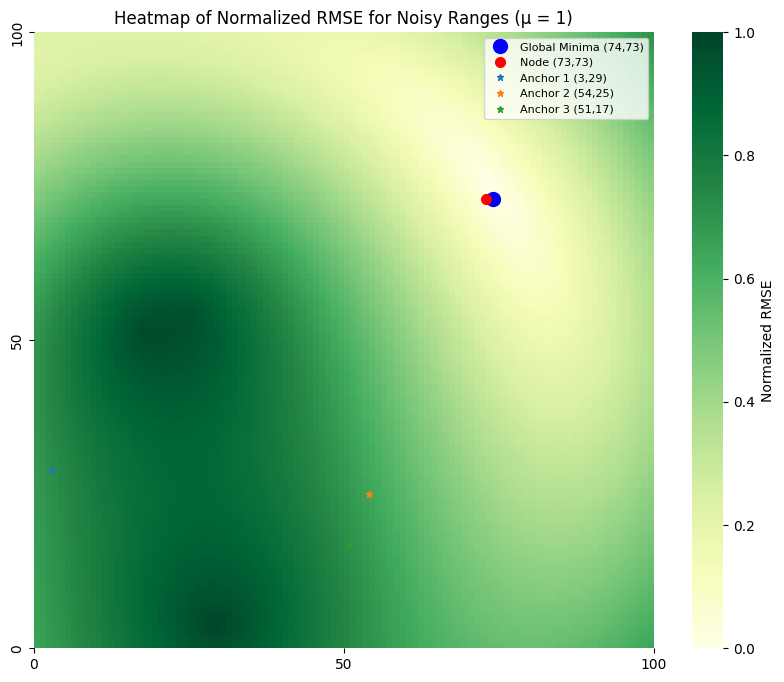

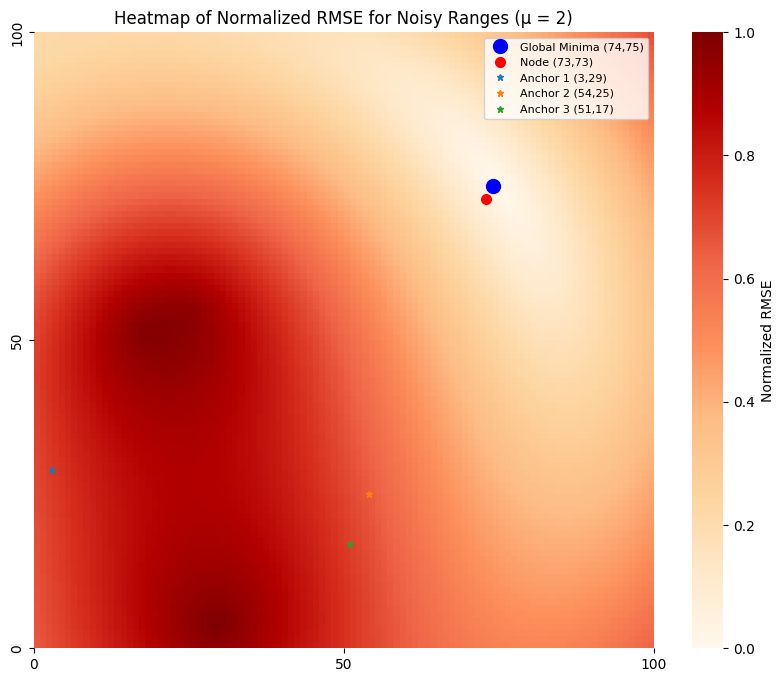

In [3]:
# Load data
true_locations = pd.read_csv(true_locations_file_path, header=0)
pure_ranges = pd.read_csv(pure_ranges_file_path, header=0)
noisy_ranges_05 = pd.read_csv(noisy_ranges_05_file_path, header=0)
noisy_ranges_1 = pd.read_csv(noisy_ranges_1_file_path, header=0)
noisy_ranges_2 = pd.read_csv(noisy_ranges_2_file_path, header=0)

# Function to calculate Euclidean distance
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# Function to calculate RMSE for a candidate (i, j)
def calculate_rmse(candidate, anchors, ranges):
    estimated_distances = [euclidean_distance(candidate, anchor) for anchor in anchors]
    rmse = np.sqrt(np.mean([(estimated_distances[k] - ranges[k])**2 for k in range(3)]))
    return rmse

# Generate random row (A) and node (B)
A = random.randint(1, 100)
# print(f"A {A}")
B = random.randint(1, 50)
# print(f"B {B}")

A = A - 1
B = B - 1 + 3

# Extract anchor and node coordinates from the chosen row
anchors = [eval(true_locations.iloc[A, i]) for i in range(3)]  # Convert strings to tuples
print(f"Anchors Co-ordinates -> {anchors}")
node = eval(true_locations.iloc[A, B])                 # Convert node coordinates to tuple
print(f"Node Co-ordinates -> {node}")
# print(f"X {X}")
# print(f"Y {Y}")

# Extract the range values for the chosen row and node from all files
pure_range = eval(pure_ranges.iloc[A, B])                   # Distances for chosen node
# print(f"pure_range {pure_range}")
noisy_range_05 = eval(noisy_ranges_05.iloc[A, B])
# print(f"noisy_range_05 {noisy_range_05}")
noisy_range_1 = eval(noisy_ranges_1.iloc[A, B])
# print(f"noisy_range_1 {noisy_range_1}")
noisy_range_2 = eval(noisy_ranges_2.iloc[A, B])
# print(f"noisy_range_2 {noisy_range_2}")

# Prepare matrices to store cost values
pure_ranges_cost_matrix = np.zeros((100, 100))
noisy_ranges_05_cost_matrix = np.zeros((100, 100))
noisy_ranges_1_cost_matrix = np.zeros((100, 100))
noisy_ranges_2_cost_matrix = np.zeros((100, 100))

# Evaluate cost function for each (i, j) in a 100x100 grid
for i in range(100):
    for j in range(100):
        candidate_location = (i, j)
        # Calculate and store RMSE-based cost values in matrices
        pure_ranges_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, pure_range)
        noisy_ranges_05_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_05)
        noisy_ranges_1_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_1)
        noisy_ranges_2_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_2)

# The resulting matrices contain RMSE cost values for each (i, j) in the grid
# print("Cost matrix for pure_ranges.csv:\n", cost_matrix_pure)
# print("Cost matrix for noisy_ranges_05.csv:\n", cost_matrix_noisy_05)
# print("Cost matrix for noisy_ranges_1.csv:\n", cost_matrix_noisy_1)
# print("Cost matrix for noisy_ranges_2.csv:\n", cost_matrix_noisy_2)


pure_ranges_cost_matrix_file_path = 'dipendu_data/pure_ranges_cost_matrix.csv'
if os.path.exists(pure_ranges_cost_matrix_file_path):
    os.remove(pure_ranges_cost_matrix_file_path)
noisy_ranges_05_cost_matrix_file_path = 'dipendu_data/noisy_ranges_05_cost_matrix.csv'
if os.path.exists(noisy_ranges_05_cost_matrix_file_path):
    os.remove(noisy_ranges_05_cost_matrix_file_path)
noisy_ranges_1_cost_matrix_file_path = 'dipendu_data/noisy_ranges_1_cost_matrix.csv'
if os.path.exists(noisy_ranges_1_cost_matrix_file_path):
    os.remove(noisy_ranges_1_cost_matrix_file_path)
noisy_ranges_2_cost_matrix_file_path = 'dipendu_data/noisy_ranges_2_cost_matrix.csv'
if os.path.exists(noisy_ranges_2_cost_matrix_file_path):
    os.remove(noisy_ranges_2_cost_matrix_file_path)

# Save cost matrices to CSV files
np.savetxt(pure_ranges_cost_matrix_file_path, pure_ranges_cost_matrix, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_05_cost_matrix_file_path, noisy_ranges_05_cost_matrix, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_1_cost_matrix_file_path, noisy_ranges_1_cost_matrix, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_2_cost_matrix_file_path, noisy_ranges_2_cost_matrix, delimiter=",", fmt="%.5f")

# print("Cost matrices saved as CSV files.")

# Function to normalize a matrix to range [0, 1]
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Normalize each cost matrix
pure_ranges_cost_matrix_normalized = normalize_matrix(pure_ranges_cost_matrix)
noisy_ranges_05_cost_matrix_normalized = normalize_matrix(noisy_ranges_05_cost_matrix)
noisy_ranges_1_cost_matrix_normalized = normalize_matrix(noisy_ranges_1_cost_matrix)
noisy_ranges_2_cost_matrix_normalized = normalize_matrix(noisy_ranges_2_cost_matrix)

pure_ranges_cost_matrix_normalized_file_path = 'dipendu_data/pure_ranges_cost_matrix_normalized.csv'
if os.path.exists(pure_ranges_cost_matrix_normalized_file_path):
    os.remove(pure_ranges_cost_matrix_normalized_file_path)
noisy_ranges_05_cost_matrix_normalized_file_path = 'dipendu_data/noisy_ranges_05_cost_matrix_normalized.csv'
if os.path.exists(noisy_ranges_05_cost_matrix_normalized_file_path):
    os.remove(noisy_ranges_05_cost_matrix_normalized_file_path)
noisy_ranges_1_cost_matrix_normalized_file_path = 'dipendu_data/noisy_ranges_1_cost_matrix_normalized.csv'
if os.path.exists(noisy_ranges_1_cost_matrix_normalized_file_path):
    os.remove(noisy_ranges_1_cost_matrix_normalized_file_path)
noisy_ranges_2_cost_matrix_normalized_file_path = 'dipendu_data/noisy_ranges_2_cost_matrix_normalized.csv'
if os.path.exists(noisy_ranges_2_cost_matrix_normalized_file_path):
    os.remove(noisy_ranges_2_cost_matrix_normalized_file_path)

# Save the normalized matrices to CSV files
np.savetxt(pure_ranges_cost_matrix_normalized_file_path, pure_ranges_cost_matrix_normalized, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_05_cost_matrix_normalized_file_path, noisy_ranges_05_cost_matrix_normalized, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_1_cost_matrix_normalized_file_path, noisy_ranges_1_cost_matrix_normalized, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_2_cost_matrix_normalized_file_path, noisy_ranges_2_cost_matrix_normalized, delimiter=",", fmt="%.5f")

# print("Normalized cost matrices saved as CSV files.")

def find_global_minima(matrix):
    # Find the minimum value in the matrix using a nested loop
    min_value = float('inf')  # Initialize with a large value
    min_index = (-1, -1)  # Placeholder for the index

    # Loop through each row and each element in the row
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value < min_value:
                min_value = value  # Update minimum value
                min_index = (i, j)  # Update index of minimum value
    
    return min_index, min_value

pure_ranges_minima_index, pure_ranges_minima_value = find_global_minima(pure_ranges_cost_matrix_normalized)
noisy_ranges_05_minima_index, noisy_ranges_05_minima_value = find_global_minima(noisy_ranges_05_cost_matrix_normalized)
noisy_ranges_1_minima_index, noisy_ranges_1_minima_value = find_global_minima(noisy_ranges_1_cost_matrix_normalized)
noisy_ranges_2_minima_index, noisy_ranges_2_minima_value = find_global_minima(noisy_ranges_2_cost_matrix_normalized)

print(f"Pure Ranges Minima Co-ordinates -> {pure_ranges_minima_index}")
print(f"Noisy Ranges 0.5 Minima Co-ordinates -> {noisy_ranges_05_minima_index}")
print(f"Noisy Ranges 1 Minima Co-ordinates -> {noisy_ranges_1_minima_index}")
print(f"Noisy Ranges 2 Minima Co-ordinates -> {noisy_ranges_2_minima_index}")

def plot_heatmap(value, min_index, title, color):
    plt.figure(figsize=(10, 8))
    sns.heatmap(value, cmap=color, alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set x-axis ticks
    plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
    plt.plot(min_index[1], min_index[0], 'bo', markersize=10, label=f"Global Minima ({min_index[1]},{min_index[0]})")
    plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
    for i, anchor in enumerate(anchors, start=1):
        plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
    plt.legend(fontsize=8)
    plt.show()

plot_heatmap(pure_ranges_cost_matrix_normalized, pure_ranges_minima_index, 'Heatmap of Normalized RMSE for Pure Ranges', "GnBu")

# plt.figure(figsize=(10, 8))
# sns.heatmap(pure_ranges_cost_matrix_normalized, cmap="GnBu", alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
# plt.title('Heatmap of Normalized RMSE for Pure Ranges')
# plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set x-axis ticks
# plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
# plt.plot(pure_ranges_minima_index[1], pure_ranges_minima_index[0], 'bo', markersize=10, label=f"Global Minima ({pure_ranges_minima_index[1]},{pure_ranges_minima_index[0]})")
# plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
# for i, anchor in enumerate(anchors):
#     plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
# plt.legend(fontsize=8)
# plt.show()

plot_heatmap(noisy_ranges_05_cost_matrix_normalized, noisy_ranges_05_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 0.5)', "PuRd")

# plt.figure(figsize=(10, 8))
# sns.heatmap(noisy_ranges_05_cost_matrix_normalized, cmap="PuRd", alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
# plt.title('Heatmap of Normalized RMSE for Noisy Ranges (μ = 0.5)')
# plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set x-axis ticks
# plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
# plt.plot(noisy_ranges_05_minima_index[1], noisy_ranges_05_minima_index[0], 'bo', markersize=10, label=f"Global Minima ({noisy_ranges_05_minima_index[1]},{noisy_ranges_05_minima_index[0]})")
# plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
# for i, anchor in enumerate(anchors):
#     plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
# plt.legend(fontsize=8)
# plt.show()

plot_heatmap(noisy_ranges_1_cost_matrix_normalized, noisy_ranges_1_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 1)', "YlGn")

# plt.figure(figsize=(10, 8))
# sns.heatmap(noisy_ranges_1_cost_matrix_normalized, cmap="YlGn", alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
# plt.title('Heatmap of Normalized RMSE for Noisy Ranges (μ = 1)')
# plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set x-axis ticks
# plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
# plt.plot(noisy_ranges_1_minima_index[1], noisy_ranges_1_minima_index[0], 'bo', markersize=10, label=f"Global Minima ({noisy_ranges_1_minima_index[1]},{noisy_ranges_1_minima_index[0]})")
# plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
# for i, anchor in enumerate(anchors):
#     plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
# plt.legend(fontsize=8)
# plt.show()

plot_heatmap(noisy_ranges_2_cost_matrix_normalized, noisy_ranges_2_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 2)', "OrRd")

# plt.figure(figsize=(10, 8))
# sns.heatmap(noisy_ranges_2_cost_matrix_normalized, cmap="OrRd", alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
# plt.title('Heatmap of Normalized RMSE for Noisy Ranges (μ = 2)')
# plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set x-axis ticks
# plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
# plt.plot(noisy_ranges_2_minima_index[1], noisy_ranges_2_minima_index[0], 'bo', markersize=10, label=f"Global Minima ({noisy_ranges_2_minima_index[1]},{noisy_ranges_2_minima_index[0]})")
# plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
# for i, anchor in enumerate(anchors):
#     plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
# plt.legend(fontsize=8)
# plt.show()


### Task 3: Trilateration. 

<div style="display:flex; overflow: hidden;">
  <div style="margin:20px;">
    <p>Now use an optimizer to solve for the node location for all 100x50 node locations (pure + 3 noisy versions). If you are using python, use lmfit (https://lmfit.github.io/lmfit-py/). Round off the output of the solver to the nearest integer value, say if the solver outputs (50.69, 45.23) - round it off to (51, 45) for the estimated location cell. Also make sure the solver knows the limits of the solution (i.e., the bounding box). Write the solvers output into 4 files, &lt;pure_locs.csv&gt;, &lt;noisy_locs_05.csv&gt;, &lt;noisy_locs_1.csv&gt; and &lt;noisy_locs_2.csv&gt;. Compare the solved locations with the entries in &lt;true_locations.csv&gt; and compute the localization errors (euclidean distance between true and estimated location).
    </p>
    <p></p>
    <p>a. Plot 4 CDFs (each for the 5000 error values) on the same graph, to compare the 4 cases.
    <p>
For the 4 cases state the: 
</p><p>
(i) median error, </p><p>
(ii) 75th percentile error,</p><p>
(iii) 95th percentile error.
    </p>
  </div>
</div>



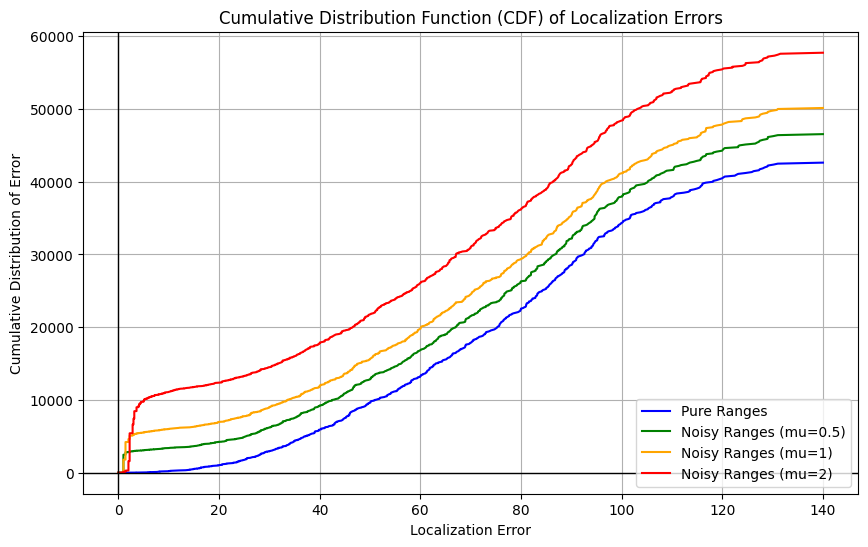

+-----------------------+----------------+-------------------------+-------------------------+
| Error Type            |   Median Error |   75th Percentile Error |   95th Percentile Error |
+=======================+================+=========================+=========================+
| Pure Ranges           |        0       |                 0       |                 73.0274 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=0.5) |        1       |                 1       |                 73.5391 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=1)   |        1.41421 |                 2       |                 73.9256 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=2)   |        2.23607 |                 3.60555 |                 75.6042 |
+-----------------------+----------------+--------

In [4]:
# Function to calculate Euclidean distance between two points (x1, y1) and (x2, y2)
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Objective function to minimize
def objective_function(params, anchors, ranges):
    # Extract the node coordinates from the parameters
    x_node = params['x_node']
    y_node = params['y_node']
    
    # Calculate the predicted distances from the node to the anchors
    predicted_ranges = []
    for anchor in anchors:
        predicted_range = euclidean_distance(x_node, y_node, anchor[0], anchor[1])
        predicted_ranges.append(predicted_range)
    
    # Calculate the residuals (difference between predicted and actual ranges)
    residuals = [predicted_ranges[i] - ranges[i] for i in range(3)]
    return residuals

# Function to solve for node location using lmfit
def solve_node_location(anchors, ranges):
    # Initial guess for the node location (e.g., average of anchors)
    initial_guess = {
        'x_node': sum([a[0] for a in anchors]) / len(anchors),
        'y_node': sum([a[1] for a in anchors]) / len(anchors)
    }
    
    # Create a Parameters object to store the node location parameters
    params = lmfit.Parameters()
    params.add('x_node', value=initial_guess['x_node'], min=0, max=100)
    params.add('y_node', value=initial_guess['y_node'], min=0, max=100)
    
    # Fit the model to minimize the objective function
    result = lmfit.minimize(objective_function, params, args=(anchors, ranges))
    
    # Extract the best fit values for the node location and convert them to standard Python float
    x_node_est = float(result.params['x_node'].value)  # Convert to Python float
    y_node_est = float(result.params['y_node'].value)  # Convert to Python float
    
    return x_node_est, y_node_est

# Function to read pure ranges and noisy ranges from CSV files
def read_ranges_from_csv(file_path):
    data = []
    with open(file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)
        all_anchors = []
        all_ranges = []
        
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]  # Anchor column indices
        range_indices = [header.index(f"Node_{i+1}") for i in range(50)]  # Range column indices
        
        for row in reader:
            # Extract anchors and ranges
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]
            ranges = [tuple(map(float, row[range_indices[i]].strip('()').split(', '))) for i in range(50)]
            data.append((anchors, ranges))
            all_anchors.append(anchors)
            all_ranges.append(ranges)
    return data, all_anchors, all_ranges

# Read data from the CSVs
pure_ranges_data, pure_ranges_anchor, pure_ranges = read_ranges_from_csv(pure_ranges_file_path)
noisy_ranges_05_data, noisy_ranges_05_anchors, noisy_ranges_05 = read_ranges_from_csv(noisy_ranges_05_file_path)
noisy_ranges_1_data, noisy_ranges_1_anchors, noisy_ranges_1 = read_ranges_from_csv(noisy_ranges_1_file_path)
noisy_ranges_2_data, noisy_ranges_2_anchors, noisy_ranges_2 = read_ranges_from_csv(noisy_ranges_2_file_path)

# print(f"{pure_ranges_anchor}")
# print(f"{pure_ranges}")
# print(f"{noisy_ranges_05_anchors}")
# print(f"{noisy_ranges_05}")
# print(f"{noisy_ranges_1_anchors}")
# print(f"{noisy_ranges_1}")
# print(f"{noisy_ranges_2_anchors}")
# print(f"{noisy_ranges_2}")

def solve_for_all_nodes(data):
    solved_nodes = []
    for anchors, ranges in data:
        # Loop through all 50 ranges for each anchor set
        node_locations = []
        for range_value in ranges:
            x_node, y_node = solve_node_location(anchors, range_value)  # Solve for each range
            node_locations.append((x_node, y_node))  # Store the solved node location as a tuple (x, y)
        solved_nodes.append(node_locations)  # Append the list of solved nodes for each anchor set
    return solved_nodes

# Solve for pure, noisy ranges (mu = 0.5, mu = 1, mu = 2)
pure_nodes = solve_for_all_nodes(pure_ranges_data)
noisy_nodes_05 = solve_for_all_nodes(noisy_ranges_05_data)
noisy_nodes_1 = solve_for_all_nodes(noisy_ranges_1_data)
noisy_nodes_2 = solve_for_all_nodes(noisy_ranges_2_data)

# # Print results
# print("Solved node locations for pure ranges:")
# print(pure_nodes)
# print("\nSolved node locations for noisy ranges (mu = 0.5):")
# print(noisy_nodes_05)
# print("\nSolved node locations for noisy ranges (mu = 1):")
# print(noisy_nodes_1)
# print("\nSolved node locations for noisy ranges (mu = 2):")
# print(noisy_nodes_2)

# Create pairs for pure ranges
def create_anchor_node_pairs(all_anchors, all_nodes):
    solved = []
    for anchors, nodes in zip(all_anchors, all_nodes):
        solved.append({"Anchor Set": anchors, "Node Set": nodes})
    return solved

pure_ranges_solved = create_anchor_node_pairs(pure_ranges_anchor, pure_nodes)
noisy_ranges_05_solved = create_anchor_node_pairs(noisy_ranges_05_anchors, noisy_nodes_05)
noisy_ranges_1_solved = create_anchor_node_pairs(noisy_ranges_1_anchors, noisy_nodes_1)
noisy_ranges_2_solved = create_anchor_node_pairs(noisy_ranges_2_anchors, noisy_nodes_2)

# Function to write true locations data to a CSV file
def write_solved_locations_to_csv(solved_locations_data, file_path):
    # Remove the file if it already exists
    if os.path.exists(file_path):
        os.remove(file_path)
    
    # Write location_data to CSV with each row representing one anchor-node pair
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        # Write each anchor-node pair in a single row
        for idx, data in enumerate(solved_locations_data):
            # Format anchor and node coordinates as (x, y) strings
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({x}, {y})" for (x, y) in data["Node Set"]]
            writer.writerow(row)

# Usage example:
pure_ranges_solved_locations_file_path = 'dipendu_data/pure_ranges_solved_locations.csv'
noisy_ranges_05_solved_locations_file_path = 'dipendu_data/noisy_ranges_05_solved_locations.csv'
noisy_ranges_1_solved_locations_file_path = 'dipendu_data/noisy_ranges_1_solved_locations.csv'
noisy_ranges_2_solved_locations_file_path = 'dipendu_data/noisy_ranges_2_solved_locations.csv'

write_solved_locations_to_csv(pure_ranges_solved, pure_ranges_solved_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_05_solved, noisy_ranges_05_solved_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_1_solved, noisy_ranges_1_solved_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_2_solved, noisy_ranges_2_solved_locations_file_path)

# # Print results to verify
# print("Pure Ranges Solved:")
# print(pure_ranges_solved)

# print("\nNoisy Ranges (mu = 0.5) Solved:")
# print(noisy_ranges_05_solved)

# print("\nNoisy Ranges (mu = 1) Solved:")
# print(noisy_ranges_1_solved)

# print("\nNoisy Ranges (mu = 2) Solved:")
# print(noisy_ranges_2_solved)


# Function to round off node coordinates to the nearest integer
def round_node_coordinates_to_int(nodes):
    return [(round(x), round(y)) for x, y in nodes]

# Round off the coordinates in all node sets to the nearest integer
pure_nodes_rounded = [round_node_coordinates_to_int(nodes) for nodes in pure_nodes]
noisy_nodes_05_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_05]
noisy_nodes_1_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_1]
noisy_nodes_2_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_2]

pure_ranges_solved_rounded = create_anchor_node_pairs(pure_ranges_anchor, pure_nodes_rounded)
noisy_ranges_05_solved_rounded = create_anchor_node_pairs(noisy_ranges_05_anchors, noisy_nodes_05_rounded)
noisy_ranges_1_solved_rounded = create_anchor_node_pairs(noisy_ranges_1_anchors, noisy_nodes_1_rounded)
noisy_ranges_2_solved_rounded = create_anchor_node_pairs(noisy_ranges_2_anchors, noisy_nodes_2_rounded)

pure_ranges_solved_rounded_locations_file_path = 'dipendu_data/pure_locs.csv'
noisy_ranges_05_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_05.csv'
noisy_ranges_1_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_1.csv'
noisy_ranges_2_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_2.csv'

write_solved_locations_to_csv(pure_ranges_solved_rounded, pure_ranges_solved_rounded_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_05_solved_rounded, noisy_ranges_05_solved_rounded_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_1_solved_rounded, noisy_ranges_1_solved_rounded_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_2_solved_rounded, noisy_ranges_2_solved_rounded_locations_file_path)

# # Print rounded results to verify
# print("Rounded Pure Nodes to Integer:")
# print(pure_nodes_rounded)

# print("\nRounded Noisy Nodes (mu = 0.5) to Integer:")
# print(noisy_nodes_05_rounded)

# print("\nRounded Noisy Nodes (mu = 1) to Integer:")
# print(noisy_nodes_1_rounded)

# print("\nRounded Noisy Nodes (mu = 2) to Integer:")
# print(noisy_nodes_2_rounded)


# Function to read node coordinates from CSV
def read_node_locations(file_path):
    node_locations = []
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            # Extract node coordinates (assumed format: "(x, y)")
            nodes = [tuple(map(int, val.strip("()").split(', '))) for val in row[3:]]
            node_locations.append(nodes)
    return node_locations

# Calculate localization error by comparing true and predicted node coordinates
def calculate_localization_error(true_nodes, predicted_nodes):
    errors = []
    for true_set, pred_set in zip(true_nodes, predicted_nodes):
        set_errors = [euclidean_distance(t[0], t[1], p[0], p[1]) for t, p in zip(true_set, pred_set)]
        errors.append(set_errors)
    return errors

# Paths to the CSV files
# true_locations_file_path = 'dipendu_data/true_locations.csv'
predicted_files = {
    "pure": 'dipendu_data/pure_locs.csv',
    "noisy_05": 'dipendu_data/noisy_locs_05.csv',
    "noisy_1": 'dipendu_data/noisy_locs_1.csv',
    "noisy_2": 'dipendu_data/noisy_locs_2.csv'
}

# Read true node locations
true_nodes = read_node_locations(true_locations_file_path)

pure_ranges_solved_nodes = read_node_locations(pure_ranges_solved_rounded_locations_file_path)
pure_ranges_solved_errors = calculate_localization_error(true_nodes, pure_ranges_solved_nodes)

noisy_ranges_05_solved_nodes = read_node_locations(noisy_ranges_05_solved_rounded_locations_file_path)
noisy_ranges_05_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_05_solved_nodes)

noisy_ranges_1_solved_nodes = read_node_locations(noisy_ranges_1_solved_rounded_locations_file_path)
noisy_ranges_1_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_1_solved_nodes)

noisy_ranges_2_solved_nodes = read_node_locations(noisy_ranges_2_solved_rounded_locations_file_path)
noisy_ranges_2_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_2_solved_nodes)


# print(f"Localization Errors for Pure:")
# for error_set in pure_ranges_solved_errors:
#     print(error_set)  # Each error set corresponds to a row in the CSV

# print(f"Localization Errors for Noisy 0.5:")
# for error_set in noisy_ranges_05_solved_errors:
#     print(error_set)  # Each error set corresponds to a row in the CSV


# print(f"Localization Errors for Noisy 1:")
# for error_set in noisy_ranges_1_solved_errors:
#     print(error_set)  # Each error set corresponds to a row in the CSV

# print(f"Localization Errors for Noisy 2:")
# for error_set in noisy_ranges_2_solved_errors:
#     print(error_set)  # Each error set corresponds to a row in the CSV

# # Process each predicted file and calculate errors
# for label, predicted_file_path in predicted_files.items():
#     predicted_nodes = read_node_locations(predicted_file_path)
#     localization_errors = calculate_localization_error(true_nodes, predicted_nodes)
    
#     # Print or process localization errors for each file as needed
#     print(f"Localization Errors for {label}:")
#     for error_set in localization_errors:
#         print(error_set)  # Each error set corresponds to a row in the CSV

# Create pairs for pure ranges
def create_anchor_node_error_pairs(all_anchors, all_nodes):
    solved = []
    for anchors, nodes in zip(all_anchors, all_nodes):
        solved.append({"Anchor Set": anchors, "Node Error": nodes})
    return solved

pure_ranges_error = create_anchor_node_error_pairs(pure_ranges_anchor, pure_ranges_solved_errors)
noisy_ranges_05_error = create_anchor_node_error_pairs(noisy_ranges_05_anchors, noisy_ranges_05_solved_errors)
noisy_ranges_1_error = create_anchor_node_error_pairs(noisy_ranges_1_anchors, noisy_ranges_1_solved_errors)
noisy_ranges_2_error = create_anchor_node_error_pairs(noisy_ranges_2_anchors, noisy_ranges_2_solved_errors)

# # Print results to verify
# print("Pure Ranges Error:")
# print(pure_ranges_error)

# print("\nNoisy Ranges (mu = 0.5) Error:")
# print(noisy_ranges_05_error)

# print("\nNoisy Ranges (mu = 1) Error:")
# print(noisy_ranges_1_error)

# print("\nNoisy Ranges (mu = 2) Error:")
# print(noisy_ranges_2_error)

# Function to write true locations data to a CSV file
def write_errors_to_csv(error_data, file_path):
    # Remove the file if it already exists
    if os.path.exists(file_path):
        os.remove(file_path)
    
    # Write location_data to CSV with each row representing one anchor-node pair
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        # Write each anchor-node pair in a single row
        for idx, data in enumerate(error_data):
            # Format anchor and node coordinates as (x, y) strings
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({error})" for error in data["Node Error"]]
            writer.writerow(row)

# Usage example:
pure_ranges_errors_file_path = 'dipendu_data/pure_ranges_errors.csv'
noisy_ranges_05_errors_file_path = 'dipendu_data/noisy_ranges_05_errors.csv'
noisy_ranges_1_errors_file_path = 'dipendu_data/noisy_ranges_1_errors.csv'
noisy_ranges_2_errors_file_path = 'dipendu_data/noisy_ranges_2_errors.csv'

write_errors_to_csv(pure_ranges_error, pure_ranges_errors_file_path)
write_errors_to_csv(noisy_ranges_05_error, noisy_ranges_05_errors_file_path)
write_errors_to_csv(noisy_ranges_1_error, noisy_ranges_1_errors_file_path)
write_errors_to_csv(noisy_ranges_2_error, noisy_ranges_2_errors_file_path)

# Function to flatten the nested list of errors
def flatten_errors(error_data):
    return [error for node_errors in error_data for error in node_errors]

# Flatten each error list
pure_errors_flat = flatten_errors(pure_ranges_solved_errors)
noisy_05_errors_flat = flatten_errors(noisy_ranges_05_solved_errors)
noisy_1_errors_flat = flatten_errors(noisy_ranges_1_solved_errors)
noisy_2_errors_flat = flatten_errors(noisy_ranges_2_solved_errors)

# List of errors and labels for easy iteration
errors_list = [pure_errors_flat, noisy_05_errors_flat, noisy_1_errors_flat, noisy_2_errors_flat]
labels = ['Pure Ranges', 'Noisy Ranges (mu=0.5)', 'Noisy Ranges (mu=1)', 'Noisy Ranges (mu=2)']
colors = ['blue', 'green', 'orange', 'red']  # Define colors for each plot line
cdf_variances = []

# Plot cumulative distribution of errors for each scenario
plt.figure(figsize=(10, 6))
for i, (errors, label, color) in enumerate(zip(errors_list, labels, colors)):
    # Sort errors and calculate cumulative distribution
    sorted_errors = np.sort(errors)
    cumulative_distribution = np.cumsum(sorted_errors)
    
    # Calculate variance of errors and cumulative distribution
    variance = np.var(errors)
    cdf_variance = np.var(cumulative_distribution)
    cdf_variances.append(cdf_variance)
    
    # Plot cumulative distribution with annotation for variance
    plt.plot(sorted_errors, cumulative_distribution, label=f'{label}', color=color)

# Customize the plot
plt.xlabel('Localization Error')
plt.ylabel('Cumulative Distribution of Error')
plt.title('Cumulative Distribution Function (CDF) of Localization Errors')
plt.legend(loc='lower right')
plt.axhline(y=0, color='black', linewidth=1)  # Horizontal axis line at y=0
plt.axvline(x=0, color='black', linewidth=1)   # Vertical axis line at x=0
plt.grid()
plt.show()

# Calculate the median, 75th percentile, and 95th percentile for each error set
def calculate_percentiles(errors):
    # Sort the errors to calculate percentiles manually
    errors_sorted = sorted(errors)
    
    # Median calculation
    median = statistics.median(errors_sorted)
    
    # 75th percentile calculation
    p75_index = int(0.75 * len(errors_sorted))
    p75 = errors_sorted[p75_index]
    
    # 95th percentile calculation
    p95_index = int(0.95 * len(errors_sorted))
    p95 = errors_sorted[p95_index]
    
    return median, p75, p95

# Calculate for each error set
pure_median, pure_p75, pure_p95 = calculate_percentiles(pure_errors_flat)
noisy_05_median, noisy_05_p75, noisy_05_p95 = calculate_percentiles(noisy_05_errors_flat)
noisy_1_median, noisy_1_p75, noisy_1_p95 = calculate_percentiles(noisy_1_errors_flat)
noisy_2_median, noisy_2_p75, noisy_2_p95 = calculate_percentiles(noisy_2_errors_flat)

# # Print results
# print(f"Pure Ranges Error: Median = {pure_median}, 75th Percentile = {pure_p75}, 95th Percentile = {pure_p95}")
# print(f"Noisy Ranges (mu=0.5) Error: Median = {noisy_05_median}, 75th Percentile = {noisy_05_p75}, 95th Percentile = {noisy_05_p95}")
# print(f"Noisy Ranges (mu=1) Error: Median = {noisy_1_median}, 75th Percentile = {noisy_1_p75}, 95th Percentile = {noisy_1_p95}")
# print(f"Noisy Ranges (mu=2) Error: Median = {noisy_2_median}, 75th Percentile = {noisy_2_p75}, 95th Percentile = {noisy_2_p95}")

# Create a dictionary with the results
data = {
    'Error Type': ['Pure Ranges', 'Noisy Ranges (mu=0.5)', 'Noisy Ranges (mu=1)', 'Noisy Ranges (mu=2)'],
    'Median Error': [pure_median, noisy_05_median, noisy_1_median, noisy_2_median],
    '75th Percentile Error': [pure_p75, noisy_05_p75, noisy_1_p75, noisy_2_p75],
    '95th Percentile Error': [pure_p95, noisy_05_p95, noisy_1_p95, noisy_2_p95]
}

# Create a DataFrame from the dictionary
error_df = pd.DataFrame(data)

# Display the DataFrame

print(tabulate(error_df, headers="keys", tablefmt="grid", showindex=False))
# print(error_df)

# Wrong TASK

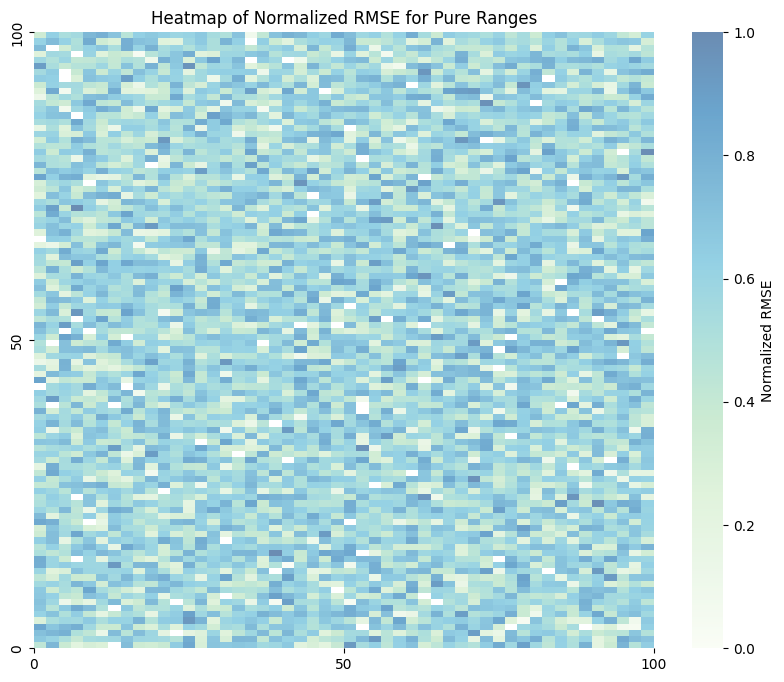

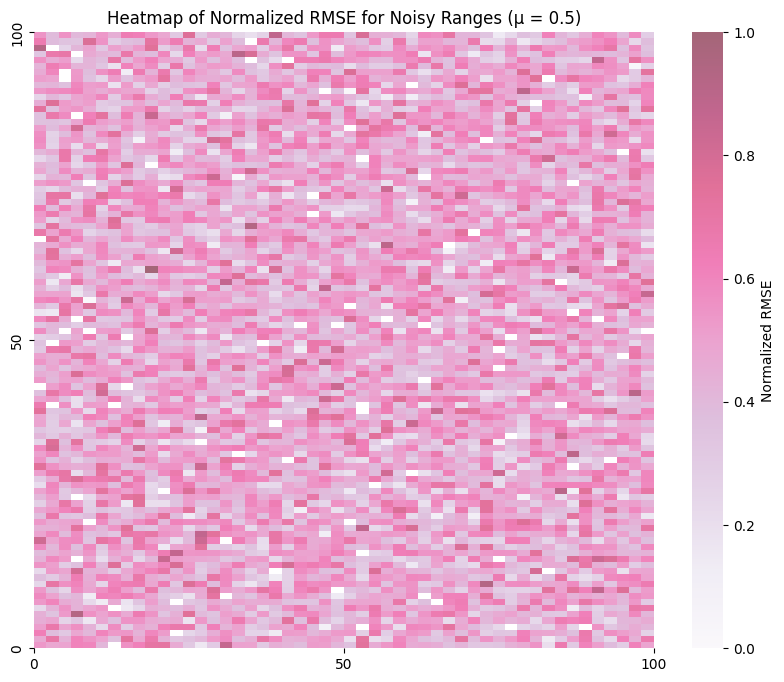

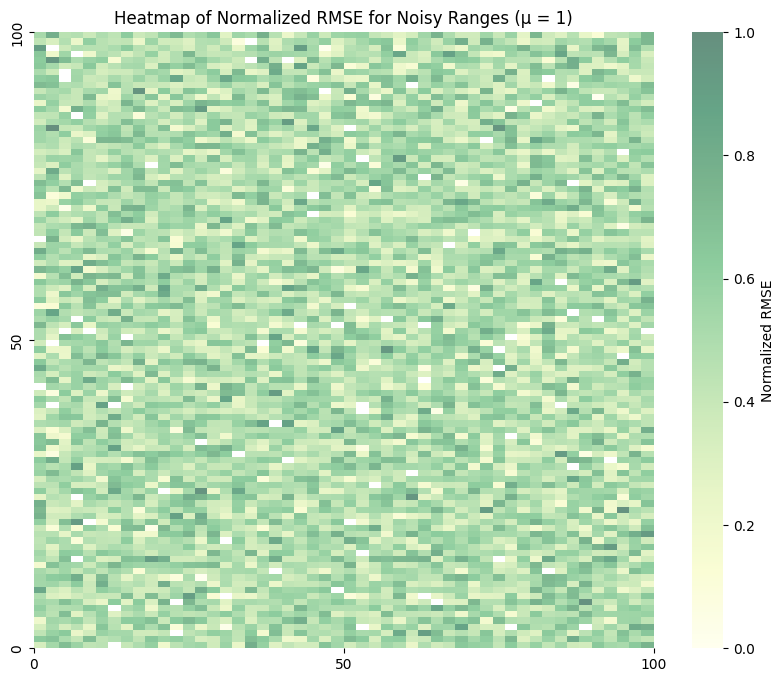

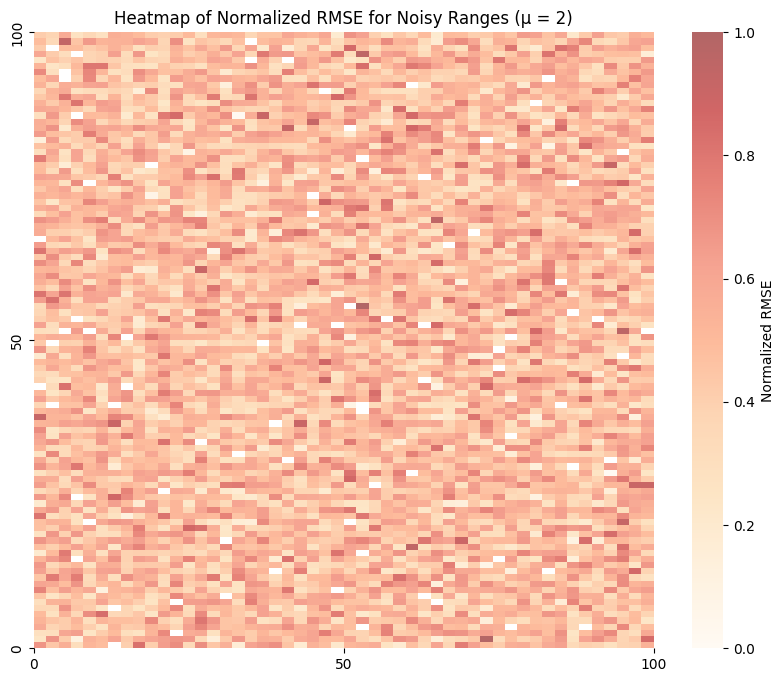

In [5]:
##==============================================================PART B. 2:a===========================================================================##

# Define function to calculate Euclidean distance using the math library
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Step 1: Read true locations and calculate Euclidean distances
def calculate_true_ranges(true_locations_file_path):
    true_ranges_data = []
    with open(true_locations_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)  # Read the header
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]  # Anchor columns
        node_indices = [header.index(f"Node_{i+1}") for i in range(50)]  # Node columns
        
        # Process each row
        for row in reader:
            # Extract anchors
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]
            
            # Extract nodes and calculate distances to each anchor
            distances = []
            for node in [tuple(map(int, row[node_idx].strip('()').split(', '))) for node_idx in node_indices]:
                # Check if node is a boundary node (x or y == 100)
                if node[0] == 100 or node[1] == 100:
                    distances.append((float('inf'), float('inf'), float('inf')))  # Set max int distance
                else:
                    # Calculate distances to each anchor
                    node_distances = tuple(euclidean_distance(node[0], node[1], anchor[0], anchor[1]) for anchor in anchors)
                    distances.append(node_distances)
            
            true_ranges_data.append({
                "anchors": anchors,
                "distances": distances  # 50 tuples of (d1, d2, d3) per node
            })
    
    return true_ranges_data

# Example usage
true_ranges_data = calculate_true_ranges(true_locations_file_path)

# print(f"true_ranges_data {true_ranges_data}")

# Step 2: Read ranges files
def read_ranges_file(file_path):
    range_data = []
    anchor_data = []
    with open(file_path, mode='r') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip header
        for row in reader:
            # Read anchors and range tuples (node-wise)
            anchors = [tuple(map(int, row[i].strip('()').split(', '))) for i in range(3)]
            ranges = [tuple(map(float, row[j].strip('()').split(', '))) for j in range(3, 53)]
            range_data.append({
                "anchors": anchors,
                "ranges": ranges  # 50 tuples of ranges (R1, R2, R3) per node
            })
            anchor_data.append(anchors)
    return range_data, anchor_data

# Load range data from each file
pure_ranges, pure_ranges_anchors = read_ranges_file(pure_ranges_file_path)
noisy_ranges_05, noisy_ranges_05_anchors = read_ranges_file(noisy_ranges_05_file_path)
noisy_ranges_1, noisy_ranges_1_anchors = read_ranges_file(noisy_ranges_1_file_path)
noisy_ranges_2, noisy_ranges_2_anchors = read_ranges_file(noisy_ranges_2_file_path)

# print(f"pure_ranges_anchors {pure_ranges_anchors}")
# print(f"pure_ranges {pure_ranges}")
# print(f"noisy_ranges_05_anchors {noisy_ranges_05_anchors}")
# print(f"noisy_ranges_05 {noisy_ranges_05}")
# print(f"noisy_ranges_1_anchors {noisy_ranges_1_anchors}")
# print(f"noisy_ranges_1 {noisy_ranges_1}")
# print(f"noisy_ranges_2_anchors {noisy_ranges_2_anchors}")
# print(f"noisy_ranges_2 {noisy_ranges_2}")

# Step 3: Calculate RMSE for ranges
def calculate_rmse(true_ranges, noisy_ranges):
    rmse_data = []
    
    for true_row, noisy_row in zip(true_ranges, noisy_ranges):
        rmse_row = []
        
        for true_distances, noisy_distances in zip(true_row["distances"], noisy_row["ranges"]):
            # Check if the true distance indicates a boundary node
            if float('inf') in true_distances:
                # Set RMSE to max int (float('inf')) for boundary nodes
                rmse = float('inf')
            else:
                # Calculate RMSE for each node without np
                squared_diffs = [(true - noisy) ** 2 for true, noisy in zip(true_distances, noisy_distances)]
                mean_squared_diff = sum(squared_diffs) / len(squared_diffs)
                rmse = math.sqrt(mean_squared_diff)
            
            rmse_row.append(rmse)
        
        rmse_data.append(rmse_row)
    
    return rmse_data

# Calculate RMSE for each set of ranges
pure_ranges_rmse = calculate_rmse(true_ranges_data, pure_ranges)
noisy_ranges_05_rmse = calculate_rmse(true_ranges_data, noisy_ranges_05)
noisy_ranges_1_rmse = calculate_rmse(true_ranges_data, noisy_ranges_1)
noisy_ranges_2_rmse = calculate_rmse(true_ranges_data, noisy_ranges_2)

# print(f"pure_ranges_rmse {pure_ranges_rmse}")
# print(f"noisy_ranges_05_rmse {noisy_ranges_05_rmse}")
# print(f"noisy_ranges_1_rmse {noisy_ranges_1_rmse}")
# print(f"noisy_ranges_2_rmse {noisy_ranges_2_rmse}")

# Step 4: Save RMSE Results to CSV Files
def write_rmse_to_csv(file_path, rmse_data, anchor_data):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        # Write each row of anchor and RMSE data
        for anchors, rmse_row in zip(anchor_data, rmse_data):
            # Format anchors as (x, y) strings
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in anchors]
            # Combine anchors and RMSE values into a single row
            row = anchor_strs + rmse_row
            writer.writerow(row)

pure_ranges_rmse_file_path = 'dipendu_data/pure_ranges_rmse.csv'
if os.path.exists(pure_ranges_rmse_file_path):
    os.remove(pure_ranges_rmse_file_path)
noisy_ranges_05_rmse_file_path = 'dipendu_data/noisy_ranges_05_rmse.csv'
if os.path.exists(noisy_ranges_05_rmse_file_path):
    os.remove(noisy_ranges_05_rmse_file_path)
noisy_ranges_1_rmse_file_path = 'dipendu_data/noisy_ranges_1_rmse.csv'
if os.path.exists(noisy_ranges_1_rmse_file_path):
    os.remove(noisy_ranges_1_rmse_file_path)
noisy_ranges_2_rmse_file_path = 'dipendu_data/noisy_ranges_2_rmse.csv'
if os.path.exists(noisy_ranges_2_rmse_file_path):
    os.remove(noisy_ranges_2_rmse_file_path)
# Save RMSE values to CSV files with anchors
write_rmse_to_csv(pure_ranges_rmse_file_path, pure_ranges_rmse, pure_ranges_anchors)
write_rmse_to_csv(noisy_ranges_05_rmse_file_path, noisy_ranges_05_rmse, noisy_ranges_05_anchors)
write_rmse_to_csv(noisy_ranges_1_rmse_file_path, noisy_ranges_1_rmse, noisy_ranges_1_anchors)
write_rmse_to_csv(noisy_ranges_2_rmse_file_path, noisy_ranges_2_rmse, noisy_ranges_2_anchors)

# Step 5: Normalize data between 0 and 1
def normalize_rmse(rmse_data):
    # Flatten the data, excluding max int (boundary nodes) for normalization
    flat_data = [val for row in rmse_data for val in row if val != float('inf')]  # Ignore infinities

    # Get the minimum and maximum values from the entire dataset, excluding infinity
    min_val, max_val = min(flat_data), max(flat_data)

    # Normalize each row and scale between 0 and 1, handling infinity as a special case
    normalized_data = []
    for row in rmse_data:
        normalized_row = []
        for val in row:
            if val == float('inf'):
                normalized_row.append(float('inf'))  # Keep 'inf' as it is
            else:
                normalized_row.append((val - min_val) / (max_val - min_val))  # Normalize between 0 and 1
        normalized_data.append(normalized_row)
    
    return normalized_data

# Normalize each RMSE dataset
pure_ranges_normalized = normalize_rmse(pure_ranges_rmse)
noisy_ranges_05_normalized = normalize_rmse(noisy_ranges_05_rmse)
noisy_ranges_1_normalized = normalize_rmse(noisy_ranges_1_rmse)
noisy_ranges_2_normalized = normalize_rmse(noisy_ranges_2_rmse)

# print(f"pure_ranges_normalized {pure_ranges_normalized}")
# print(f"noisy_ranges_05_normalized {noisy_ranges_05_normalized}")
# print(f"noisy_ranges_1_normalized {noisy_ranges_1_normalized}")
# print(f"noisy_ranges_2_normalized {noisy_ranges_2_normalized}")

# Step 6: Save normalized Results to CSV Files
def write_normalized_to_csv(file_path, normalized_data, anchor_data):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        # Write each row of anchor and normalized data
        for anchors, normalized_row in zip(anchor_data, normalized_data):
            # Format anchors as (x, y) strings
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in anchors]
            # Combine anchors and normalized values into a single row
            row = anchor_strs + normalized_row
            writer.writerow(row)

pure_ranges_normalized_file_path = 'dipendu_data/pure_ranges_normalized.csv'
if os.path.exists(pure_ranges_normalized_file_path):
    os.remove(pure_ranges_normalized_file_path)
noisy_ranges_05_normalized_file_path = 'dipendu_data/noisy_ranges_05_normalized.csv'
if os.path.exists(noisy_ranges_05_normalized_file_path):
    os.remove(noisy_ranges_05_normalized_file_path)
noisy_ranges_1_normalized_file_path = 'dipendu_data/noisy_ranges_1_normalized.csv'
if os.path.exists(noisy_ranges_1_normalized_file_path):
    os.remove(noisy_ranges_1_normalized_file_path)
noisy_ranges_2_normalized_file_path = 'dipendu_data/noisy_ranges_2_normalized.csv'
if os.path.exists(noisy_ranges_2_normalized_file_path):
    os.remove(noisy_ranges_2_normalized_file_path)
# Save normalized values to CSV files with anchors
write_normalized_to_csv(pure_ranges_normalized_file_path, pure_ranges_normalized, pure_ranges_anchors)
write_normalized_to_csv(noisy_ranges_05_normalized_file_path, noisy_ranges_05_normalized, noisy_ranges_05_anchors)
write_normalized_to_csv(noisy_ranges_1_normalized_file_path, noisy_ranges_1_normalized, noisy_ranges_1_anchors)
write_normalized_to_csv(noisy_ranges_2_normalized_file_path, noisy_ranges_2_normalized, noisy_ranges_2_anchors)

# Step 7: Create a single heatmap for comparison
plt.figure(figsize=(10, 8))
sns.heatmap(pure_ranges_normalized, cmap="GnBu", alpha=0.6, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
plt.title('Heatmap of Normalized RMSE for Pure Ranges')
plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 25, 50], labels=['0', '25', '50'])  # Set x-axis ticks
plt.xticks(ticks=[0, 25, 50], labels=['0', '50', '100'])  # Set x-axis ticks
plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(noisy_ranges_05_normalized, cmap="PuRd", alpha=0.6, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
plt.title('Heatmap of Normalized RMSE for Noisy Ranges (μ = 0.5)')
plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 25, 50], labels=['0', '25', '50'])  # Set x-axis ticks
plt.xticks(ticks=[0, 25, 50], labels=['0', '50', '100'])  # Set x-axis ticks
plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(noisy_ranges_1_normalized, cmap="YlGn", alpha=0.6, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
plt.title('Heatmap of Normalized RMSE for Noisy Ranges (μ = 1)')
plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 25, 50], labels=['0', '25', '50'])  # Set x-axis ticks
plt.xticks(ticks=[0, 25, 50], labels=['0', '50', '100'])  # Set x-axis ticks
plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(noisy_ranges_2_normalized, cmap="OrRd", alpha=0.6, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
plt.title('Heatmap of Normalized RMSE for Noisy Ranges (μ = 2)')
plt.gca().invert_yaxis()  # Invert the y-axis
# plt.xticks(ticks=[0, 25, 50], labels=['0', '25', '50'])  # Set x-axis ticks
plt.xticks(ticks=[0, 25, 50], labels=['0', '50', '100'])  # Set x-axis ticks
plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis ticks
plt.show()

# print(f"PART B. 2:a. Heat Map plotted for normalized data")